In [1]:
from Data_utils import *
from constants import *

# Creating a dataset object 
dataset = Dataset( 
	csv_file="../../og/train.csv", 
	image_dir="../../og/images/", 
	label_dir="../../og/labels/", 
	grid_sizes=[13, 26, 52], 
	anchors=ANCHORS, 
	transform=test_transform 
) 

/Applications/anaconda3/envs/ai/lib/python3.11/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


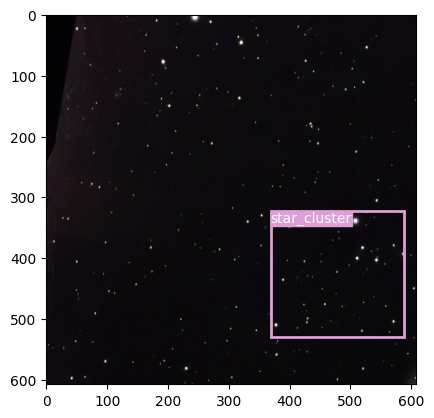

In [2]:
# Creating a dataloader object 
loader = torch.utils.data.DataLoader( 
	dataset=dataset, 
	batch_size=1, 
	shuffle=True, 
) 

# Defining the grid size and the scaled anchors 
GRID_SIZE = [13, 26, 52] 
scaled_anchors = torch.tensor(ANCHORS) / ( 
	1 / torch.tensor(GRID_SIZE).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2) 
)

# Getting a batch from the dataloader 
x, y = next(iter(loader))

# Getting the boxes coordinates from the labels 
# and converting them into bounding boxes without scaling 
boxes = [] 
for i in range(y[0].shape[1]): 
	anchor = scaled_anchors[i] 
	boxes += convert_cells_to_bboxes( 
			y[i], is_predictions=False, s=y[i].shape[2], anchors=anchor 
			)[0] 

# Applying non-maximum suppression 
boxes = nms(boxes, iou_threshold=1, threshold=0.7) 

# Plotting the image with the bounding boxes 
plot_image(x[0].permute(1,2,0).to("cpu"), boxes)

In [3]:
from model import *

# Testing YOLO v3 model 
if __name__ == "__main__": 
    # Setting number of classes and image size 
    num_classes = 3
    IMAGE_SIZE = 608
  
    # Creating model and testing output shapes 
    model = YOLOv3(num_classes=num_classes) 
    x = torch.randn((1, 3, IMAGE_SIZE, IMAGE_SIZE)) 
    out = model(x) 
    print(out[0].shape) 
    print(out[1].shape) 
    print(out[2].shape) 
  
    # Asserting output shapes 
    assert model(x)[0].shape == (1, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5) 
    assert model(x)[1].shape == (1, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5) 
    assert model(x)[2].shape == (1, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5) 
    print("Output shapes are correct!")

torch.Size([1, 3, 19, 19, 8])
torch.Size([1, 3, 38, 38, 8])
torch.Size([1, 3, 76, 76, 8])
Output shapes are correct!


In [4]:
bboxes = np.roll(np.loadtxt(fname='/Users/fouk/Documents/cosmic-object-scanner/og/labels/0a2b8ffd-2211.txt', 
						delimiter=" ", ndmin=2), 4, axis=1).tolist() 

In [5]:
bboxes

[[0.4490889603429796,
  0.6993569131832796,
  0.5294748124330116,
  0.5434083601286173,
  2.0]]

In [6]:
from model_utils import *
from torch import optim
from constants import *
from model import *

# Creating the model from YOLOv3 class 
model = YOLOv3().to(device) 
  
# Defining the optimizer 
optimizer = optim.Adam(model.parameters(), lr = leanring_rate) 
  
# Defining the loss function 
loss_fn = YOLOLoss() 
  
# Defining the scaler for mixed precision training 
scaler = torch.cuda.amp.GradScaler() 
  
# Defining the train dataset 
train_dataset = Dataset( 
    csv_file="../../og/train.csv", 
    image_dir="../../og/images/", 
    label_dir="../../og/labels/", 
    anchors=ANCHORS, 
    transform=train_transform 
) 
  
# Defining the train data loader 
train_loader = torch.utils.data.DataLoader( 
    train_dataset, 
    batch_size = batch_size, 
    num_workers = 2, 
    shuffle = True, 
    pin_memory = True, 
) 
  
# Scaling the anchors 
scaled_anchors = ( 
    torch.tensor(ANCHORS) * 
    torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1,3,2) 
).to(device) 
  
# Training the model 
for e in range(1, epochs+1): 
    print("Epoch:", e) 
    training_loop(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors) 
  
    # Saving the model 
    if save_model: 
        save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

/Applications/anaconda3/envs/ai/lib/python3.11/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch: 1


  0%|          | 0/145 [00:00<?, ?it/s]/Applications/anaconda3/envs/ai/lib/python3.11/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/Applications/anaconda3/envs/ai/lib/python3.11/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float

RuntimeError: MPS backend out of memory (MPS allocated: 7.43 GB, other allocations: 1.41 GB, max allowed: 9.07 GB). Tried to allocate 722.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
# Taking a sample image and testing the model 
  
# Setting the load_model to True 
load_model = True
  
# Defining the model, optimizer, loss function and scaler 
model = YOLOv3().to(device) 
optimizer = optim.Adam(model.parameters(), lr = leanring_rate) 
loss_fn = YOLOLoss() 
scaler = torch.cuda.amp.GradScaler() 
  
# Loading the checkpoint 
if load_model: 
    load_checkpoint(checkpoint_file, model, optimizer, leanring_rate) 
  
# Defining the test dataset and data loader 
test_dataset = Dataset( 
    csv_file="./data/pascal voc/test.csv", 
    image_dir="./data/pascal voc/images/", 
    label_dir="./data/pascal voc/labels/", 
    anchors=ANCHORS, 
    transform=test_transform 
) 
test_loader = torch.utils.data.DataLoader( 
    test_dataset, 
    batch_size = 1, 
    num_workers = 2, 
    shuffle = True, 
) 
  
# Getting a sample image from the test data loader 
x, y = next(iter(test_loader)) 
x = x.to(device) 
  
model.eval() 
with torch.no_grad(): 
    # Getting the model predictions 
    output = model(x) 
    # Getting the bounding boxes from the predictions 
    bboxes = [[] for _ in range(x.shape[0])] 
    anchors = ( 
            torch.tensor(ANCHORS) 
                * torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2) 
            ).to(device) 
  
    # Getting bounding boxes for each scale 
    for i in range(3): 
        batch_size, A, S, _, _ = output[i].shape 
        anchor = anchors[i] 
        boxes_scale_i = convert_cells_to_bboxes( 
                            output[i], anchor, s=S, is_predictions=True
                        ) 
        for idx, (box) in enumerate(boxes_scale_i): 
            bboxes[idx] += box 
model.train() 
  
# Plotting the image with bounding boxes for each image in the batch 
for i in range(batch_size): 
    # Applying non-max suppression to remove overlapping bounding boxes 
    nms_boxes = nms(bboxes[i], iou_threshold=0.5, threshold=0.6) 
    # Plotting the image with bounding boxes 
    plot_image(x[i].permute(1,2,0).detach().cpu(), nms_boxes)